## Simple anomaly detection in conn.log with Local Outlier Factor
Date: 15.3.2019

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
from pyod.models.lof import LOF

## 1. Load data

In [20]:
features = pd.read_csv('conn_log_features.csv')

/Users/alperovich/miniconda3/envs/aaic/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
features.head()

,Unnamed: 0,ts,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,orig_bytes,orig_bytes_num,tick
0,0,1.5454e+09,192.168.1.196,59932.0,104.248.160.24,80.0,tcp,S0,0,0,1
1,1,1.5454e+09,192.168.1.196,59932.0,104.248.160.24,80.0,tcp,S0,0,0,1
2,2,1.5454e+09,192.168.1.196,35883.0,192.168.1.1,53.0,udp,S0,78,78,1
3,3,1.5454e+09,192.168.1.196,43531.0,192.168.1.1,53.0,udp,S0,78,78,1
4,4,1.5454e+09,192.168.1.196,59932.0,104.248.160.24,80.0,tcp,S0,0,0,1


Let's consider only connections from an interested IP address

In [22]:
infected_ip = '192.168.1.196'

In [23]:
features = features[features['id.orig_h'] == infected_ip] 

## 2. Create a simple frequency feature

Sum of requests per 5 seconds

In [24]:
def get_sample_group_by_s(time_df, num_s=5, num_sample=5000, func=sum):
    pd_offset_freq = f"{num_s}S"
    group_df = time_df.groupby(pd.TimeGrouper(pd_offset_freq))
    freq_feature = group_df['num'].apply(func)
    if num_sample:
        freq_feature_sample = freq_feature.sample(num_sample).sort_index()
    else:
        freq_feature_sample = freq_feature.sort_index()
    return freq_feature_sample

In [8]:
time_index = features['ts'][:-1]
time_index = pd.to_datetime(time_index, unit='s')
time_df = pd.DataFrame({'num': [1] * len(time_index)}, index=time_index)

In [9]:
freq_feature_sample = get_sample_group_by_s(time_df, num_s=5, num_sample=1000, func=sum)

/Users/alperovich/miniconda3/envs/aaic/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  This is separate from the ipykernel package so we can avoid doing imports until


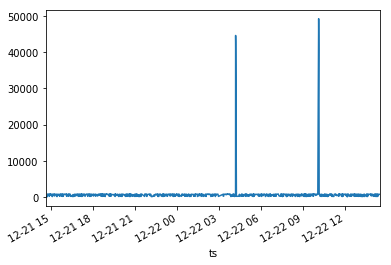

In [12]:
freq_feature_sample.plot.line()

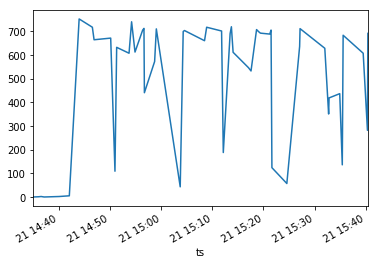

In [15]:
freq_feature_sample[:50].plot.line()

## Apply simple anomaly detector (LOF)

In [27]:
def get_anomaly_score(past_data, current_point, clf):
    clf.fit(past_data)
    y_pred = clf.predict(current_point)[0]  # outlier labels (0 or 1)
    y_score = clf.decision_function(current_point)[0]  # outlier scores
    return y_pred, y_score

def get_model_result(data: pd.DataFrame, clf, min_window=50, include_all_past=False):
    """
    Return y_preds, y_scores for a clf and data
    :param data: pd.DataFrame with features
    :param clf: classifier
    :param min_window: rolling window size. If None - then full past history will be used.
    :param include_all_past: if True, history [0, i + window] will be used for training. If False, then [i, i + window]
    :return: tuple of lists, y_preds, y_scores
    """
    data.reset_index(drop=True, inplace=True)
    n = len(data)
    columns = [col for col in data.columns if col not in ['y_pred', 'y_score']]
    y_preds = (min_window + 1) * [0]
    y_scores = (min_window + 1) * [0]
    for i in range(n - min_window - 1):
        if include_all_past:
            start_i = 0
        else:
            start_i = i
        past_data = data[columns].loc[start_i:i + min_window, :]
        next_i = i + min_window + 1
        current_point = data[columns].loc[next_i, :].values.reshape(1, -1)
        y_pred, y_score = get_anomaly_score(past_data, current_point, clf)
        y_preds.append(y_pred)
        y_scores.append(y_score)
    return y_preds, y_scores

In [81]:
outliers_fraction = 0.01
clf = LOF(n_neighbors=35, contamination=outliers_fraction)
clf_name = 'LOF'

In [82]:
data = pd.DataFrame(freq_feature_sample)

In [83]:
RESULT_TAIL = {'y_true': freq_feature_sample}
RESULT_ROLLING = {'y_true': freq_feature_sample}

## 1st strategy: Use all previous history for training, analyse the next value

In [84]:
y_preds, y_scores = get_model_result(data, clf, min_window=50, include_all_past=True)
y_pred_key = f'{clf_name}_y_pred'
y_score_key = f'{clf_name}_y_score'
RESULT_TAIL[y_pred_key] = y_preds
RESULT_TAIL[y_score_key] = y_scores

## 2nd strategy: Rolling window, use only it for training, analyse the next value

In [85]:
y_preds, y_scores = get_model_result(data, clf, min_window=50, include_all_past=False)
y_pred_key = f'{clf_name}_y_pred'
y_score_key = f'{clf_name}_y_score'
RESULT_ROLLING[y_pred_key] = y_preds
RESULT_ROLLING[y_score_key] = y_scores

In [86]:
RESULT_DF_TAIL = pd.DataFrame(RESULT_TAIL)
RESULT_DF_TAIL.to_csv('result_ad_tailcsv')
RESULT_DF_ROLL = pd.DataFrame(RESULT_ROLLING)
RESULT_DF_ROLL.to_csv('result_ad_roll.csv')

## 1st strategy results

In [87]:
RESULT_DF_TAIL.head()

,y_true,LOF_y_pred,LOF_y_score
ts,,,
2018-12-21 14:35:00,0,0,0.0
2018-12-21 14:36:05,1,0,0.0
2018-12-21 14:36:35,2,0,0.0
2018-12-21 14:37:10,0,0,0.0
2018-12-21 14:40:05,2,0,0.0


**LOF scores explained:**

score ~ 1 means Similar density as neighbors, <br>
score < 1 means Higher density than neighbors (Inlier), <br>
score > 1 means Lower density than neighbors (Outlier) <br>

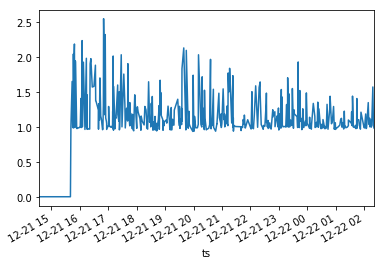

In [88]:
RESULT_DF_TAIL.LOF_y_score[:500].plot.line()

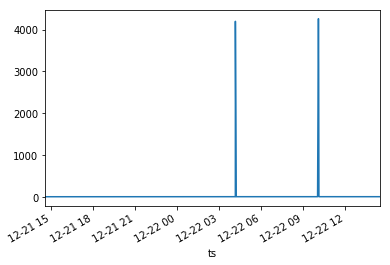

In [89]:
RESULT_DF_TAIL.LOF_y_score.plot.line()

In [90]:
# outliers 

RESULT_DF_TAIL.query('LOF_y_pred == 1').shape

(9, 3)

In [108]:
outliers = RESULT_DF_TAIL.query('LOF_y_pred == 1')
outliers_ts = list(outliers.index)

In [109]:
outliers

,y_true,LOF_y_pred,LOF_y_score
ts,,,
2018-12-21 16:50:30,504,1,2.552598
2018-12-21 20:35:50,744,1,1.969461
2018-12-22 04:09:00,755,1,2.456557
2018-12-22 04:10:20,44657,1,4196.312468
2018-12-22 04:10:35,32788,1,2952.725939
2018-12-22 04:10:45,42914,1,3639.070736
2018-12-22 10:06:35,49302,1,4259.066448
2018-12-22 10:07:20,42117,1,3473.888346
2018-12-22 10:07:35,40749,1,3168.531511


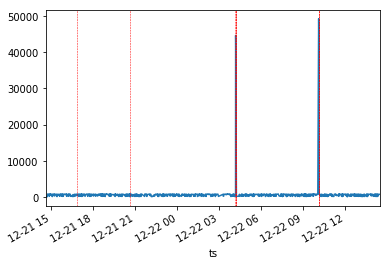

In [96]:
ax = RESULT_DF_TAIL.y_true.plot.line()

for out_ts in outliers_ts:
    ax.axvline(out_ts, color='r', linestyle='--', lw=0.5)

## 2nd strategy results

In [104]:
outliers = RESULT_DF_ROLL.query('LOF_y_pred == 1')
outliers_ts = list(outliers.index)

In [105]:
outliers.shape

(17, 3)

In [107]:
outliers

,y_true,LOF_y_pred,LOF_y_score
ts,,,
2018-12-21 16:30:10,49,1,1.396735
2018-12-21 18:50:50,57,1,2.553367
2018-12-21 21:15:50,27,1,1.100774
2018-12-21 21:16:05,13,1,1.113443
2018-12-22 03:50:15,54,1,6.134690
2018-12-22 04:10:20,44657,1,565.112984
2018-12-22 04:10:35,32788,1,383.371595
2018-12-22 04:10:45,42914,1,433.896518
2018-12-22 07:30:45,87,1,1.116388


We see much more outliers found (less information to train)

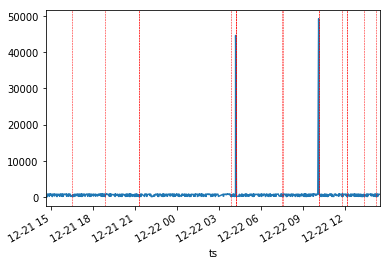

In [102]:
ax = RESULT_DF_ROLL.y_true.plot.line()

for out_ts in outliers_ts:
    ax.axvline(out_ts, color='r', linestyle='--', lw=0.5)

## Conclusion:

1. We used one simple feature: the number of connections during 5 seconds
2. We used LOF algorithm for anomaly detection
3. We looked at 2 strategies to predict anomaly:
   * Look every time at the whole history back -> then predict next
   * Rolling window -> then predict next
4. 2nd approach predicts more outliers that the 1st one because it has less historical data to learn from
5. 1st approach found 9 outliers at the contamination level 0.01 (which is used for thresholding)